In [117]:
import numpy as np
import sep

# additional setup for reading the test image and displaying plots
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

In [118]:
#identify file name
image_fits = "hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"

#read in data
hdu_1 = fits.open(image_fits)

#get the image data
data_1 = hdu_1[0].data
data_1 = data_1.byteswap(inplace=True).newbyteorder()  
#this byteswap operation is suggested at the end of the tutorial
#it says "astropy.io.fits always returns big-endian byte order arrays
#even on little endian machines"(not sure what this means)

## Plotting the raw image

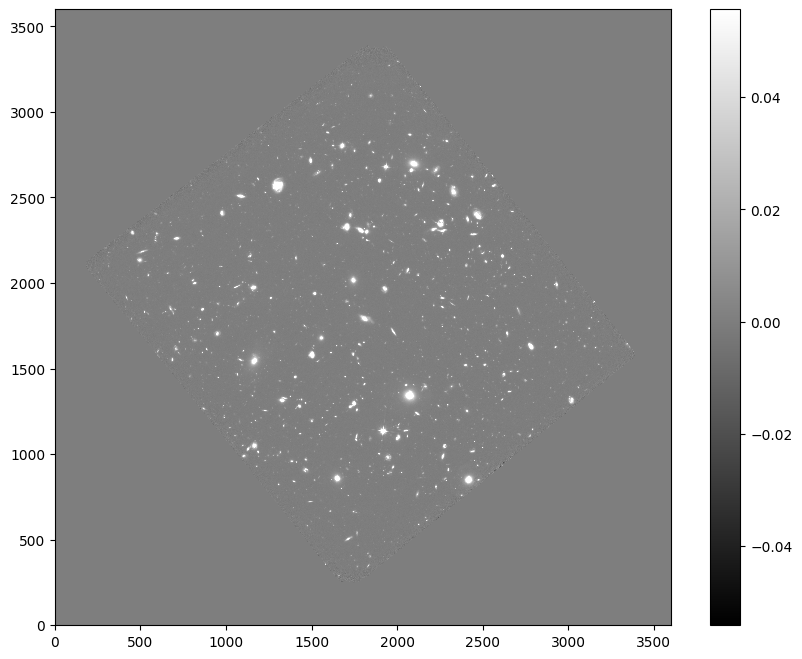

In [119]:
rcParams['figure.figsize'] = [10., 8.]
fig = plt.figure

# show the image
m, s = np.mean(data_1), np.std(data_1)
plt.imshow(data_1, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
# What are interpolation and origin?

plt.colorbar();
plt.savefig('Raw_image_f105.png',bbox_inches='tight',dpi=400)

## Background subtraction
Most optical/IR data must be background subtracted before sources can be detected. In SEP, background estimation and source detection are two separate steps.

In [120]:
# measure a spatially varying background on the image
bkg = sep.Background(data_1)

This returns an Background object that holds information on the spatially varying background and spatially varying background noise level. 

How do I apply a mask during background subtraction and do I need to apply one for this project?


In [121]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


## Next, we plot the background

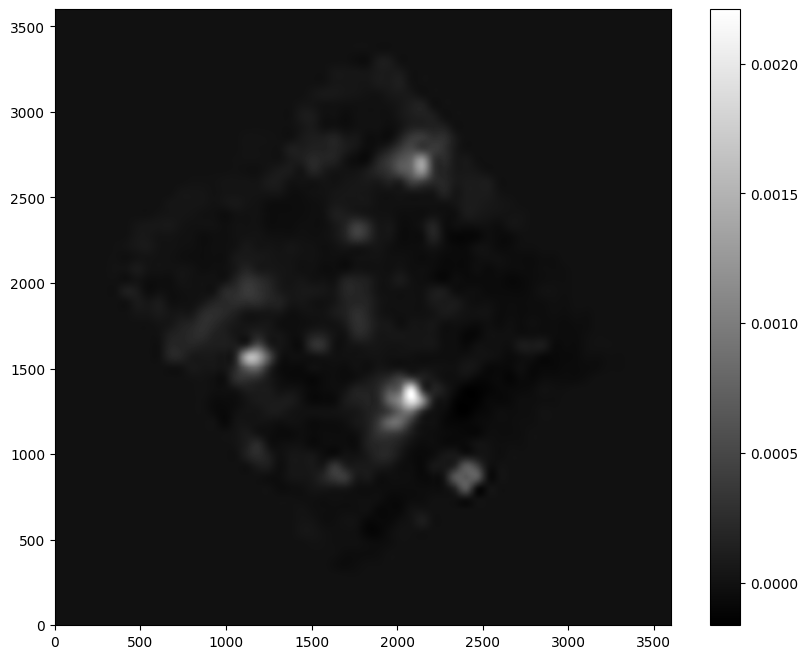

In [122]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()

# bkg_image = np.array(bkg) # equivalent to above
fig = plt.figure

# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('Background_data_f105.png',bbox_inches='tight',dpi=400)

## Next, we plot the background noise

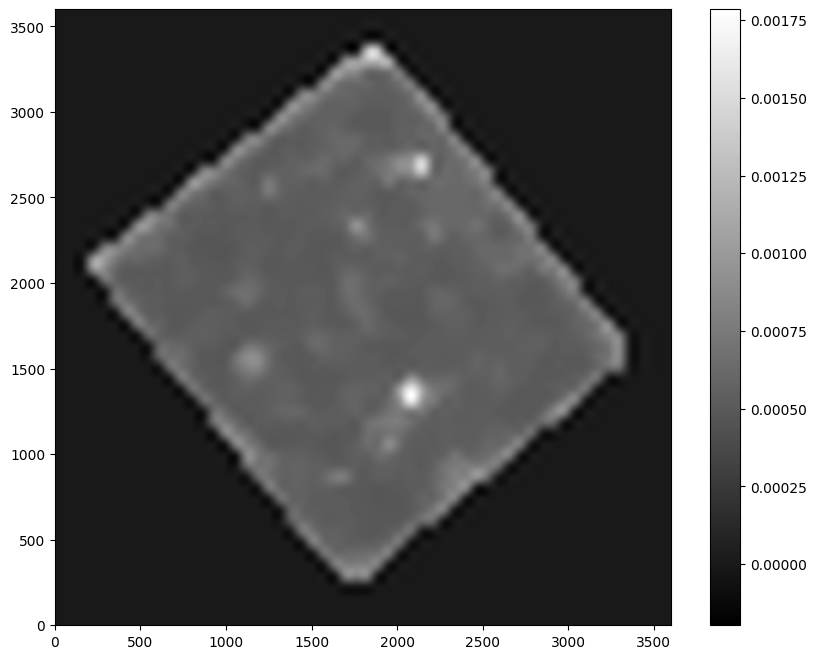

In [123]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()
fig = plt.figure

# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('Background_noise_f105.png',bbox_inches='tight',dpi=400)

In [124]:
# subtract the background and we are now ready to detect
data_sub = (data_1) - bkg

## Object detection
As the background noise level is pretty flat, the detection threshold can be set to a constant value of 1.5σ, where  is the global background RMS.

What happens if the background noise level is not flat? How do I set the detection threshold in this case?

In [125]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)
#objects is a NumPy structured array with many fields.

In [126]:
# how many objects were detected
len(objects)
print("The number of sources detected is", len(objects))

The number of sources detected is 8628


### The number of sources detected is 8650

## Encircling the detected objects

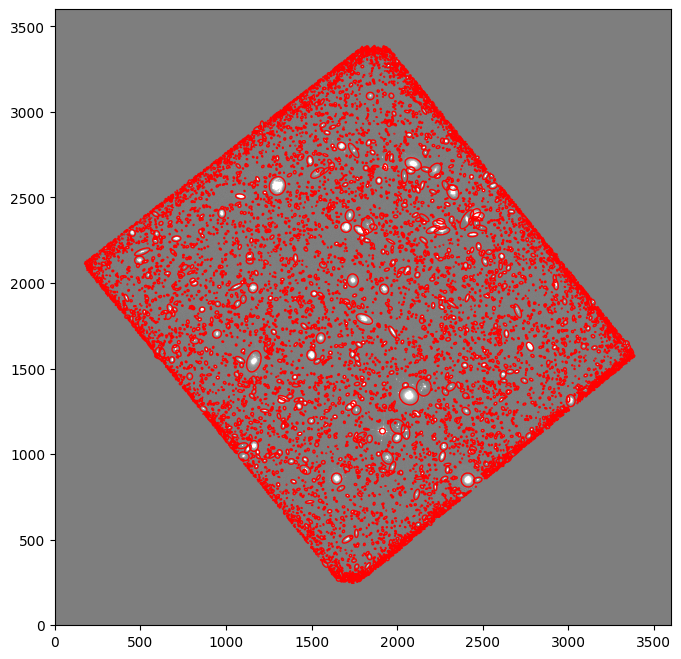

In [127]:
#objects['x'] and objects['y'] will give the centroid coordinates(locations of the center) of the objects.
from matplotlib.patches import Ellipse

# plot background-subtracted image; data_sub
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig('Obj_detection_f105.png',bbox_inches='tight',dpi=400)

In [128]:
# available fields
#objects.dtype.names

In [129]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)
#flux, fluxerr and flag are all 1-d arrays with one entry per object.

#Returns:
#flux:ndarray- The sum of the data array within the aperture.

#fluxerr:ndarray-Error on the sum.

#flags:ndarray-Integer giving flags. (0 if no flags set.)

In [130]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


## Now we plot a histogram of the fluxes


In [169]:
def histogram_plot(x,
                   flag_save = True, #save the figure?
                   label= 'z', 
                   xlabel='bins', #x-axis label
                   ylabel='N of events in the bin', #y-axis label
                   lcolor='salmon', #line color
                   fs=14, #font size
                   fname='histogram_plot.pdf'): #default plot filename

                   #label the bins
                   nbins=15
                   width = (np.ceil(max(x))-(np.floor(min(x))))/nbins
                   width = np.ceil(width)
                   print("The bin width used in the histogram plot is", width)
                   histmin = np.floor(min(x))
                   histmax = np.ceil(max(x))+width
                   print(f"The minimum and the maximum values are {min(x):4.3f} and {max(x):4.3f}")
                   bins = np.arange(histmin, histmax, width)
                   f, ax = plt.subplots(1,1,figsize=(6,6))
                   
                   #plot y vs. x
                   ax.hist(x,facecolor=lcolor,bins=bins,edgecolor='black',alpha=1.0, label = label)
                   #define a figure and axis
                   ax.set_xlabel(xlabel,fontsize=fs)
                   ax.set_ylabel(ylabel,fontsize=fs)
                   
                   #plt.xlim(0,15)
                   #plt.ylim(0, 100)
                   
                   ax.legend(loc='upper right',frameon=False)
                   #save the plot?
                   if(flag_save):
                       plt.savefig('Histogram_f105_hubble.png', bbox_inches='tight',dpi=400)

The bin width used in the histogram plot is 54.0
The minimum and the maximum values are -1.061 and 807.297


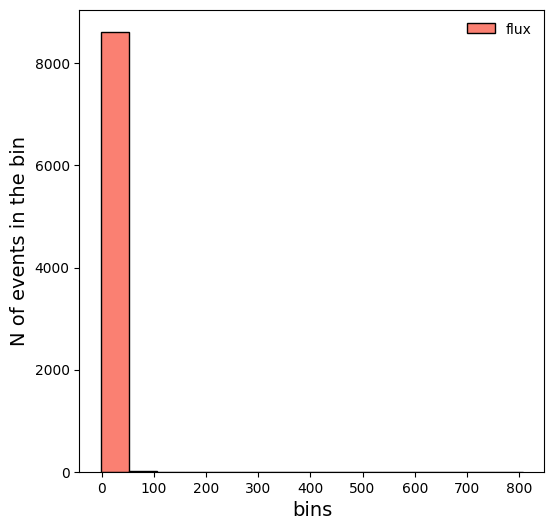

In [170]:
histogram_plot(flux,label='flux',fname= 'Histflux_f105.pdf')

## Analysis of the Histogram
## The bin size calculated is 54.0. The height of the first bin in our plot is greater than 8500. The second bin is just about visible. Even though the maximum flux observed is greater than 800, most of the objects detected lie in the first bin and have flux less than 54 

In [158]:
print(f'The Mean of the observed fluxes is {np.mean(flux):4.3f}')

print(f'The Median of the observed fluxes is {np.median(flux):4.3f}')

print(f'The Standard Deviation of the observed fluxes is {np.std(flux):4.3f}')

print(f'The largest outlier on the distribution is {max(flux): 4.3f}')

std_dev_num = (max(flux)-np.mean(flux))/(np.std(flux))
print(f'The outlier is {std_dev_num: 4.3f} standard deviations away from the mean')

The Mean of the observed fluxes is 0.362
The Median of the observed fluxes is 0.031
The Standard Deviation of the observed fluxes is 9.250
The largest outlier on the distribution is  807.297
The outlier is  87.237 standard deviations away from the mean


## Computed Statistics of the observed fluxes
### Mean = 0.362

### Median = 0.031

### Standard Deviation = 9.250

### The largest outlier on the distribution has flux = 807.297

### The outlier is  87.237 standard deviations away from the mean

In [157]:
i_outlier = (np.argmax(flux))
#print(i_outlier)
#print(flux[i_outlier])

theta_outlier = objects['theta'][i_outlier] # a, b, and theta are ellipse parameters returned by the sep.extract function as part of the object's array
a_outlier = objects['a'][i_outlier]         # a and b correspond to height and width of the ellipse   
b_outlier = objects['b'][i_outlier]         # theta corresponds to the tilt of the elli7pse
x_outlier = objects['x'][i_outlier]     # x is the x coordinate of the outlier
y_outlier =  objects['y'][i_outlier]    # y is the y coordinate of the outlier 

In [144]:
print(f'The x and y coordinates of the largest outlier on the image are ({x_outlier:4.3f}, {y_outlier:4.3f})')

The x and y coordinates of the largest outlier on the image are (1914.255, 1134.316)


### The x and y coordinates of the largest outlier on the image are (1914.255, 1134.316) 
### The outlier is encircled in yellow in the figure below

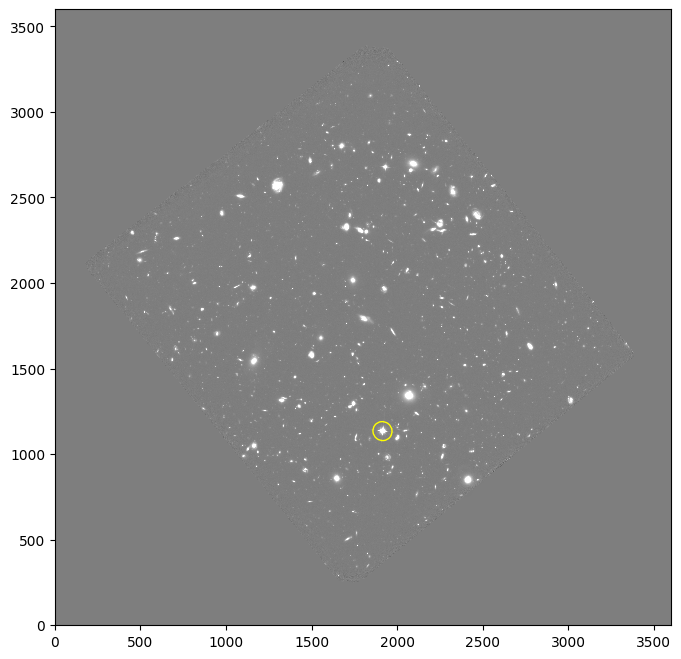

In [171]:
#objects['x'] and objects['y'] will give the centroid coordinates(locations of the center) of the objects.
from matplotlib.patches import Ellipse

# plot background-subtracted image; data_sub
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
e = Ellipse(xy=(objects['x'][i_outlier], objects['y'][i_outlier]),
            width=20*objects['a'][i_outlier],
            height=20*objects['b'][i_outlier],
            angle=objects['theta'][i_outlier] * 180. / np.pi)
e.set_facecolor('none')
e.set_edgecolor('yellow')
ax.add_artist(e)
plt.savefig('Outlier_f105_data.png',bbox_inches='tight',dpi=400)

## Next, we create a 3-color false image of the UDF using 3 files

In [146]:
# we rescale and return the data with this function
def rescale_images(data):
    pdata_tmp = data.copy()
    m = np.nanmean(pdata_tmp)
    vplmin = m/2
    vpmin = np.log10(vplmin)
    vpmax = np.log10(m * 100)
    pdata_tmp[pdata_tmp<vplmin] = vplmin
    pdata_tmp = np.log10(pdata_tmp)
    return pdata_tmp, vpmin, vpmax

In [147]:
#identify file names
f125_hubble = "hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits"
f160_hubble = "hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits"
f105_hubble = "hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"

#read in data
hdu_1 = fits.open(f125_hubble)
hdu_2 = fits.open(f160_hubble)
hdu_3 = fits.open(f105_hubble)

#get the image data
data_1 = hdu_1[0].data
data_1 = data_1.byteswap(inplace=True).newbyteorder()
data_2 = hdu_2[0].data
data_2 = data_2.byteswap(inplace=True).newbyteorder()
data_3 = hdu_3[0].data
data_3 = data_3.byteswap(inplace=True).newbyteorder()

In [148]:
# rescaling the images and limiting the data to lie in between the max and min values
data_1_res, d1min, d1max = rescale_images(data_1) 
data_2_res, d2min, d2max = rescale_images(data_2) 
data_3_res, d3min, d3max = rescale_images(data_3) 

## Create and save(as a PNG file) a 3-color false image of the UDF using RGB.
### f160: data_2, 0: Red
### f125: data_1, 1: Green
### f105: data_3, 2: Blue 

In [174]:
#creating the rgb data
rgb = np.zeros((data_1_res.shape[0], data_1_res.shape[1], 3))    #creating a matrix  of the same dimension of the data
rgb[:,:,1] = (data_1_res-d1min)/(d1max-d1min) #1:green
rgb[:,:,0] = (data_2_res-d2min)/(d2max-d2min) #0:red
rgb[:,:,2] = (data_3_res-d3min)/(d3max-d3min) #2:blue

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


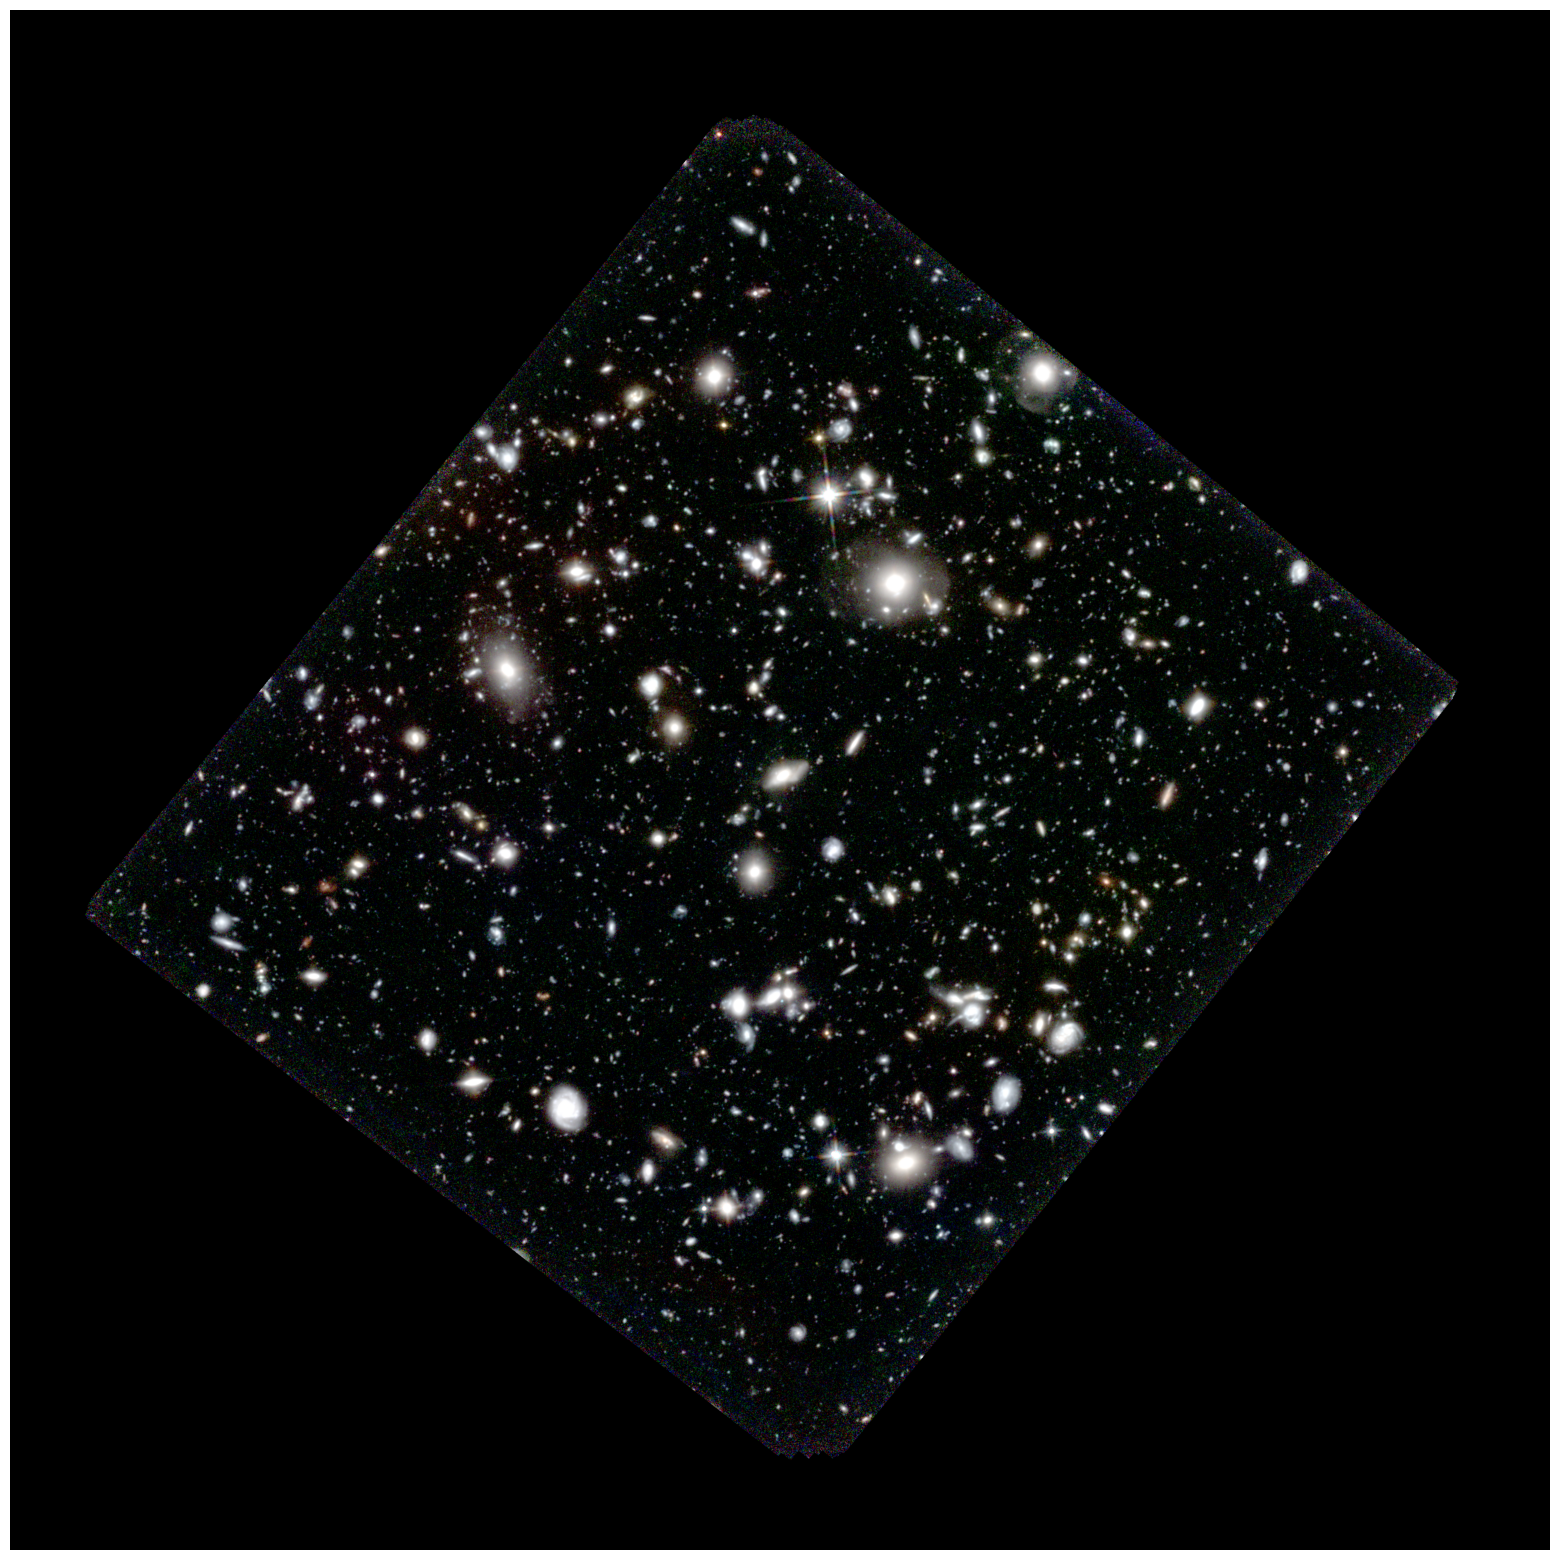

In [175]:
#plot the image
f, ax = plt.subplots(1,1, figsize=(20,20))
ax.axis('off')
ax.imshow(rgb)
plt.savefig("RGB_3color_img.png", bbox_inches= 'tight',pad_inches = 0,dpi =600) 